In [1]:
import sys
import os
from pathlib import Path

sys.path.append(Path.cwd().parent.joinpath("source").as_posix())

from utils import read_tiff, plot_sar, save_tiff, generate_graphs_from_pixel_coords
import plotly.offline as pyo
import plotly.graph_objects as go
import mvalab

# Set notebook mode to work in offline
pyo.init_notebook_mode()

import re
import numpy as np

from typing import Optional

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

import random
random.seed(1)

from copy import deepcopy
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending"
image_paths = []
for file in sorted(os.listdir(data_dir)):
    if file.endswith(".tif"):
        filepath = os.path.join(data_dir, file)
        image_paths.append(filepath)

# Temporal series

## Average temporal backscatter profiles over the whole image after S1Tiling using $\sigma_0$

Assuming that in each pixel we have $\sigma_0$ i.e. the backscatter signal, we can plot its average value through time over the whole image. Note that this does not mean much, it would be better to compute this temporal series over a smaller patch of interested (e.g. an area where there was deforestation throughout the period vs an area where the forest was kept intact).

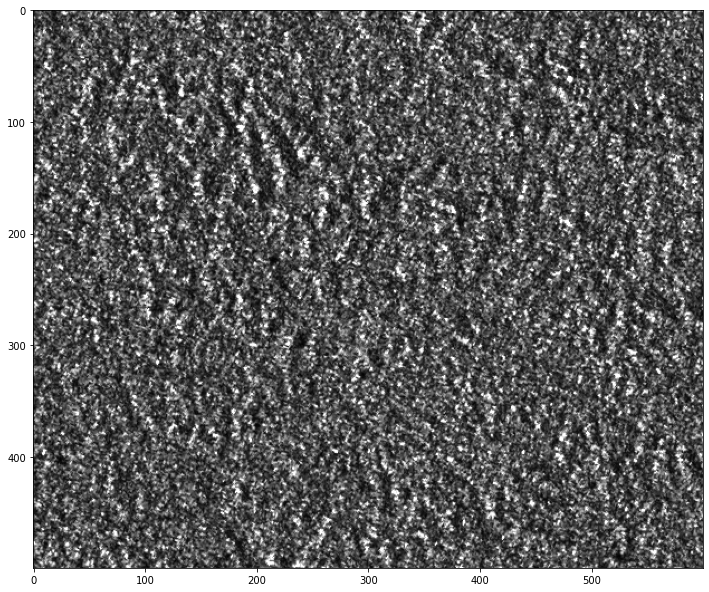

In [3]:
# Quick visualization to start
im = read_tiff(image_paths[0])
plot_sar(im)

In [4]:
im.shape

(500, 600)

In [5]:
im.mean(), im.std()

(0.2686941104868846, 0.17091600562730783)

### Express $\gamma_0$ in dB

In [6]:
epsilon = 1e-7

In [7]:
temporal_means = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending",
    title = 'Average gamma_0 over all pixels per date',
    x_title = "Date",
    y_title = "gamma_0 (dB)",
    gamma0 = True,
    epsilon = epsilon,
    pixel_coords = None,
    offsets = None,
    return_results = True
)

## Average temporal backscatter profiles over the whole image after RCR (10log10 being taken)

In [8]:
temporal_means_rcr = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/RCR/cropped/ascending",
    title = 'Average RCR over all pixels per date',
    x_title = "Date",
    y_title = "RCR (dB)",
    gamma0 = False,
    epsilon = epsilon,
    pixel_coords = None,
    offsets = None,
    return_results = True
)

### Mean $\gamma_0$ and RCR


In [9]:
pattern = r"20[0-9]{6}"
x = [re.findall(pattern, path)[0] for path in image_paths]
x = [datetime.strptime(date, "%Y%m%d") for date in x]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=temporal_means,
                    mode='lines+markers',
                    name='mean gamma_0'))
fig.add_trace(go.Scatter(x=x, y=temporal_means_rcr,
                    mode='lines+markers',
                    name='mean RCR'))
fig.update_layout(title='Average RCR and gamma_0 over all pixels per date',
                   xaxis_title='Date',
                   yaxis_title='RCR / gamma_0 (dB)')
fig.show()

## Small visualization

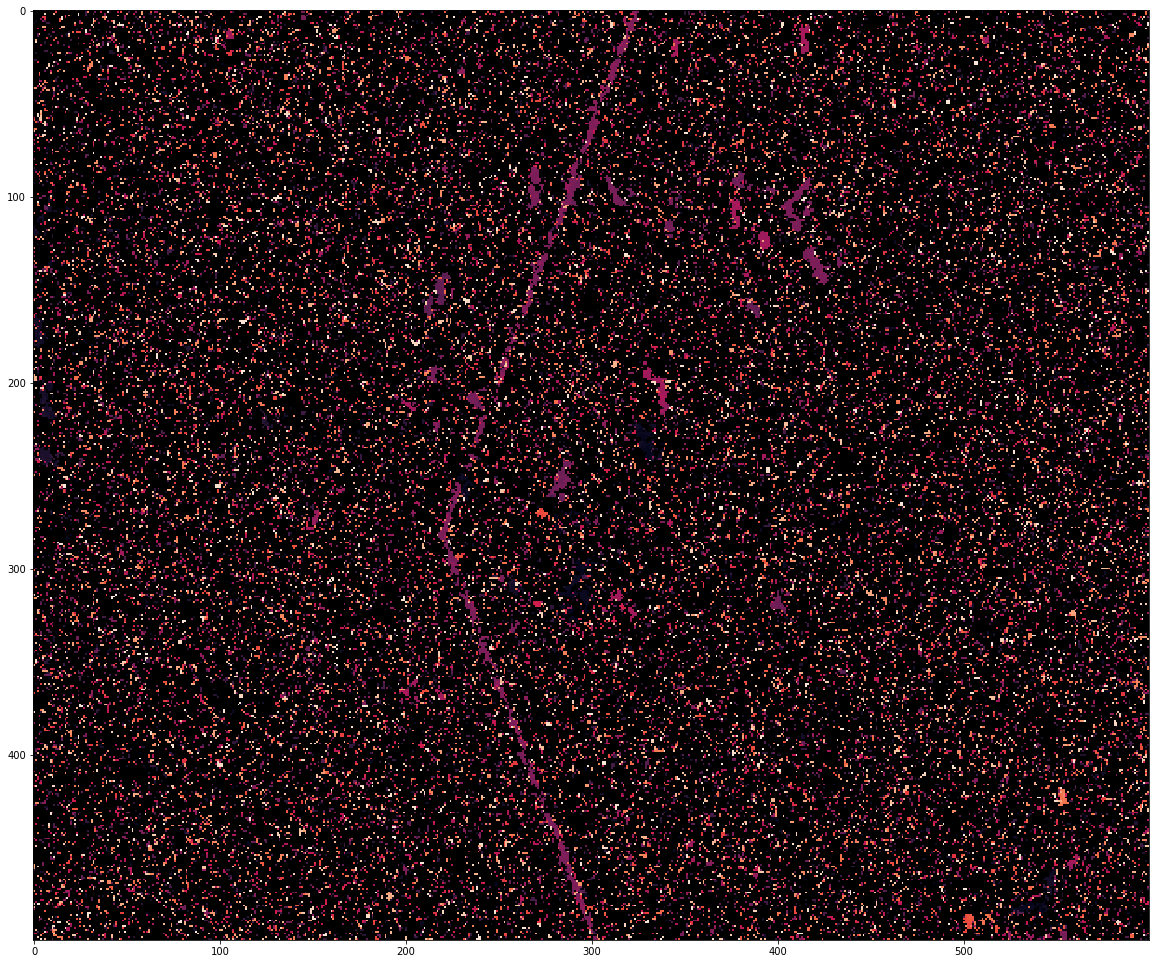

In [10]:
index_shadows = read_tiff('/mnt/hdd/SAR_images/processed/shadows/cropped/ascending/detected_shadows_image_indexes.tif')

colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(index_shadows) +1)))
color_index_shadows = colors[index_shadows.astype(int) + 1]
plt.imshow(color_index_shadows, interpolation='nearest')
plt.show()
plt.imsave( '/mnt/hdd/SAR_images/processed/shadows/cropped/ascending/colored_index.png', color_index_shadows)

### After outliers filtering with threshold = 16

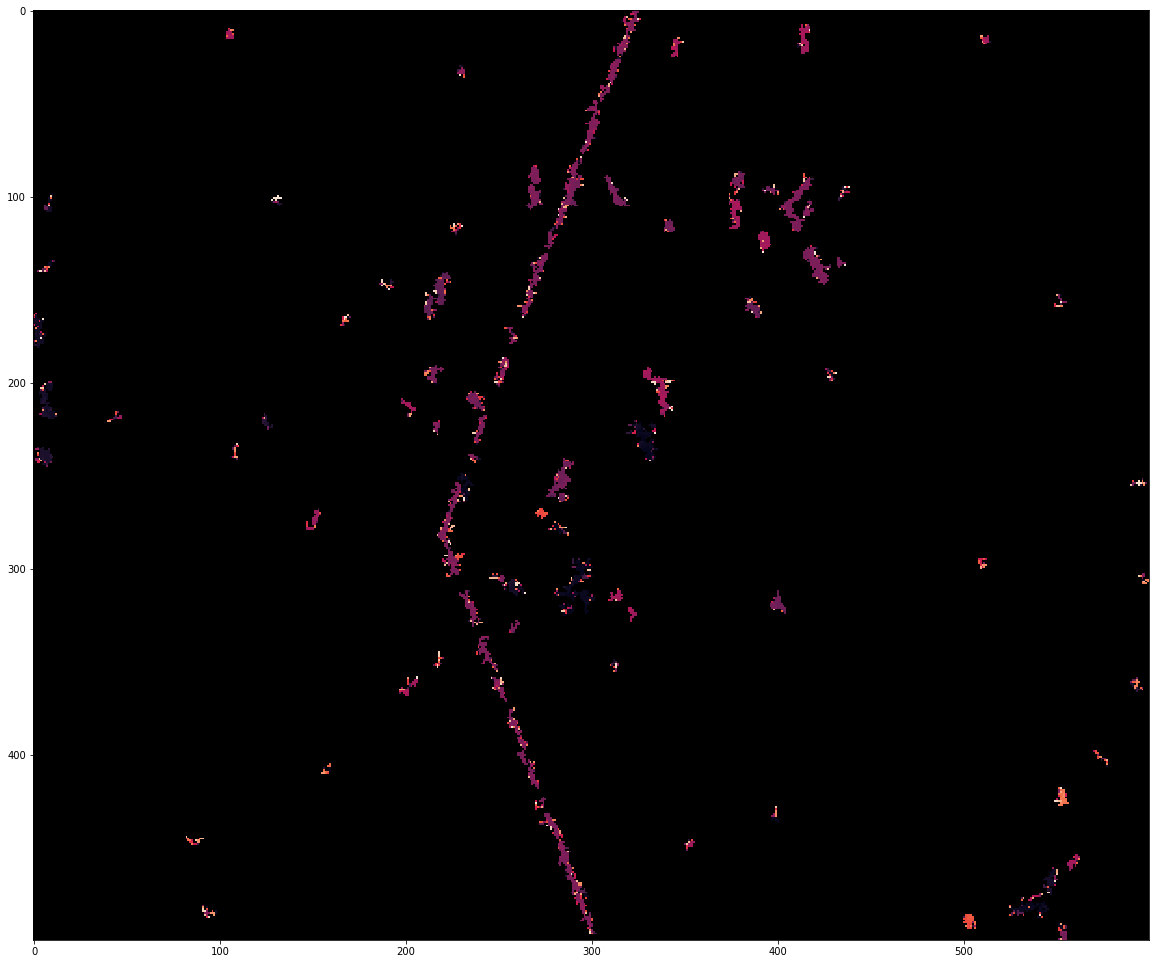

In [11]:
index_shadows = read_tiff('/mnt/hdd/SAR_images/processed/shadows/cropped/ascending/filtered_shadow_image_threshold_16.tif')

colors = np.array([[0,0,0]] + sns.color_palette("rocket",n_colors=int(np.max(index_shadows) +1)))
color_index_shadows = colors[index_shadows.astype(int) + 1]
plt.imshow(color_index_shadows, interpolation='nearest')
plt.show()
plt.imsave('/mnt/hdd/SAR_images/processed/shadows/cropped/ascending/colored_filtered_shadow_image_threshold_16.png', color_index_shadows)

# Focus on smaller patches where deforestation happened

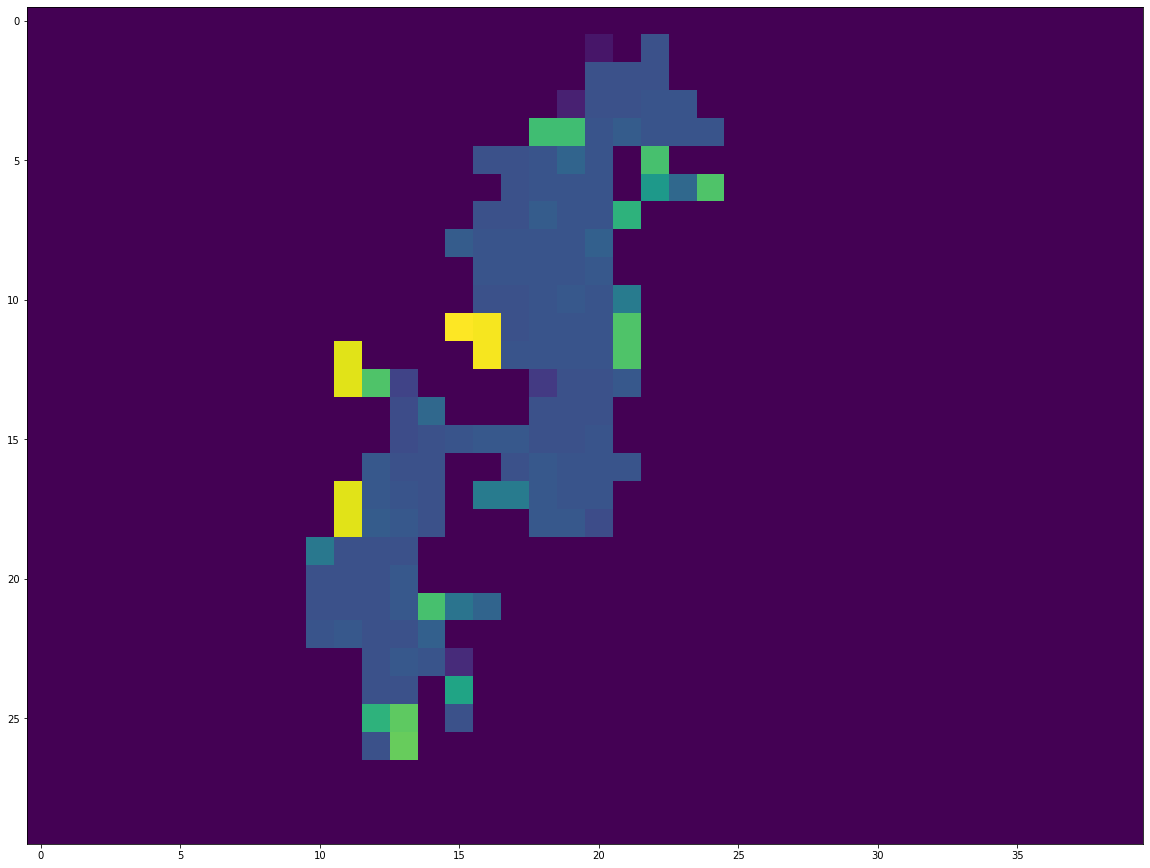

In [12]:
patch_deforested1 = index_shadows[140:170, 200:240]
cropped_coords1 = [140, 170, 200, 240]
plt.imshow(patch_deforested1)
plt.show()

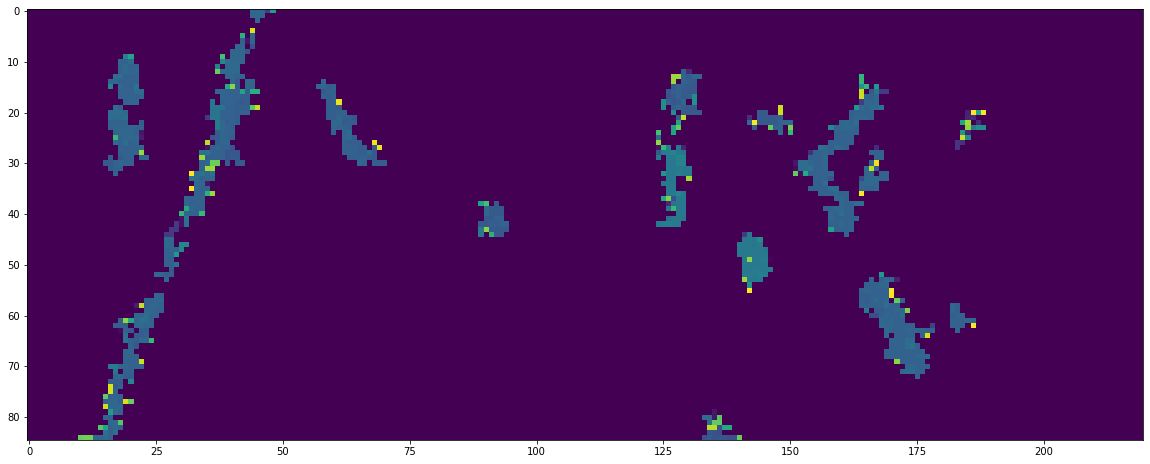

In [13]:
patch_deforested2 = index_shadows[75:160, 250:470]
cropped_coords2 = [75, 160, 250, 470]
plt.imshow(patch_deforested2)
plt.show()

# Take a look at $\gamma_0$ and RCR on the first tiny crop

In [14]:
temporal_means_patch = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending",
    title = 'Average gamma_0 over all pixels per date, over a patch that has been deforested',
    x_title = "Date",
    y_title = "gamma_0 (dB)",
    gamma0 = True,
    epsilon = epsilon,
    pixel_coords = cropped_coords1,
    offsets = None,
    return_results = True
)

In [15]:
temporal_means_rcr_patch = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/RCR/cropped/ascending",
    title = 'Average RCR over all pixels per date, using gamma_0, over a patch that has been deforested',
    x_title = "Date",
    y_title = "RCR (dB)",
    gamma0 = False,
    epsilon = epsilon,
    pixel_coords = cropped_coords1,
    offsets = None,
    return_results = True
)

# Look at the same values but for one pixel only 

In [16]:
patch_deforested1[8:12,17:21]

array([[16., 16., 16., 19.],
       [16., 16., 16., 17.],
       [15., 16., 17., 16.],
       [15., 16., 16., 16.]])

In [17]:
# min should habe been reached in 
image_paths[16]

'/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending/20160311.tif'

In [18]:
offsets = [140, 200]
pixel_coords = [8, 12, 17, 21]

In [19]:
temporal_means_pixel_def = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending",
    title = 'Average gamma_0 over all pixels per date, over a patch that has been deforested',
    x_title = "Date",
    y_title = "gamma_0 (dB)",
    gamma0 = True,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

In [20]:
temporal_means_rcr_pixel_def = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/RCR/cropped/ascending",
    title = 'Average RCR over all pixels per date, using gamma_0, over a patch that has been deforested',
    x_title = "Date",
    y_title = "RCR (dB)",
    gamma0 = False,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

- `temporal_means_rcr`: contains the RCR for the given pixel where deforestation happened (note that the RCR can be seen as the derivative of the backscattered signal)

# Find pixel where no deforestation happened

In [21]:
patch_deforested1[25:28, 0:1]

array([[-1.],
       [-1.],
       [-1.]])

In [22]:
offsets = [140, 200]
pixel_coords = [25,28,0,1]

In [23]:
temporal_means_pixel_no_def = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending",
    title = 'Average gamma_0 over a patch where no deforestation happened',
    x_title = "Date",
    y_title = "gamma_0 (dB)",
    gamma0 = True,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

In [24]:
temporal_means_rcr_pixel_no_def = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/RCR/cropped/ascending",
    title = 'Average RCR using gamma_0, over a patch where no deforestation happened',
    x_title = "Date",
    y_title = "RCR (dB)",
    gamma0 = False,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

# Take a look at a lodged area (not only the border as previously)

In [25]:
patch_deforested1[10:16, 20:24]

array([[16., 26., -1., -1.],
       [16., 46., -1., -1.],
       [16., 46., -1., -1.],
       [15., 17., -1., -1.],
       [15., -1., -1., -1.],
       [16., -1., -1., -1.]])

In [26]:
offsets = [140, 200]
pixel_coords = [10, 16, 20, 24]

In [27]:
temporal_means_pixel_lodged = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/18MUU/cropped/ascending",
    title = 'Average gamma_0 over a lodged area',
    x_title = "Date",
    y_title = "gamma_0 (dB)",
    gamma0 = True,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

In [28]:
temporal_means_rcr_pixel_lodged = generate_graphs_from_pixel_coords(
    data_dir = "/mnt/hdd/SAR_images/processed/RCR/cropped/ascending",
    title = 'Average RCR using gamma_0 over a lodged area',
    x_title = "Date",
    y_title = "RCR (dB)",
    gamma0 = False,
    epsilon = epsilon,
    pixel_coords = pixel_coords,
    offsets = offsets,
    return_results = True
)

# Visualize the three area in the same graph

- shadow: temporal_means_pixel_def
- lodged: temporal_means_pixel_lodged
- forest: temporal_means_pixel_no_def

In [32]:
pattern = r"20[0-9]{6}"
x = [re.findall(pattern, path)[0] for path in image_paths]
x = [datetime.strptime(date, "%Y%m%d") for date in x]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=temporal_means_pixel_def,
                    mode='lines+markers',
                    name='shadow'))
fig.add_trace(go.Scatter(x=x, y=temporal_means_pixel_lodged,
                    mode='lines+markers',
                    name='lodged area'))
fig.add_trace(go.Scatter(x=x, y=temporal_means_pixel_no_def,
                    mode='lines+markers',
                    name='intact forest'))
fig.update_layout(title='Temporal backscatter proﬁles of an area being logged, the corresponding shadow <br> (on one of its edges when deforestation occurs) and an intact forest',
                   xaxis_title='Date',
                   yaxis_title='gamma_0 (dB)')
fig.show()